In [1]:
from matplotlib.patches import Rectangle, Circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import wandb

import torch
import torch.nn as tnn

np.set_printoptions(linewidth=180)

## UNet Model Construction

In [2]:
class UNet(tnn.Module):
    def __init__(self, name: str, in_channels: int, out_channels: int, autoencoder: tuple[int, int, float], upsample: bool, _print: bool = False):
        """
            Build the UNet model
            upsample: using upsampling or tranpose convolution
            in_channels: Number of channels in input
            out_channels: Number of channels in output
            autoencoder:
                0: initial number of channels in autoencoder steps
                1: Number of steps
                2: Encoder channel increase rate | decoder channel decrease rate
                    eg: encoder_decoder = (32, 2, 2) has 2 steps at each autoencoder step
                    * Step 0: Down(in_channels = 32, out_channels = 32 * 2)
                    * Step 1: Down(in_channels = 32 * 2, out_channels = 32 * 2 * 2)
                    * Step 2: Bottleneck(in_channels = 32 * 2 * 2, mid_channels = 32 * 2 * 2 * 2, out_channels = 32 * 2 * 2)
                    * Step 3 (0): Up(in_channels = 32 * 2 * 2, out_channels = 32 * 2)
                    * Step 4 (1): Up(in_channels = 32 * 2, out_channels = 32)
        """
        super().__init__()
        autoencoder_initial_channels, autoencoder_steps, autoencoder_rate = autoencoder 
        self.autoencoder_config = {
            'initial_channels': autoencoder_initial_channels,
            'steps': autoencoder_steps,
            'rate': autoencoder_rate
        } 
        self.unet_config = {
            'name': name,
            'upsample': upsample
        }

        self.input_step = UNet.DoubleConv(
            in_channel=in_channels, 
            out_channel=autoencoder_initial_channels
        )
        self.encoder_steps = tnn.ModuleList([UNet.Down(
            in_channel=int(autoencoder_initial_channels * (autoencoder_rate**i)),
            out_channel=int(autoencoder_initial_channels * (autoencoder_rate**(i + 1)))
        ) for i in range(autoencoder_steps)])
        self.bottleneck = UNet.Bottleneck(
            in_channel=int(autoencoder_initial_channels * (autoencoder_rate**autoencoder_steps)),
            mid_channel=int(autoencoder_initial_channels * (autoencoder_rate**(autoencoder_steps + 1))),
            out_channel=int(autoencoder_initial_channels * (autoencoder_rate**autoencoder_steps)),
            upsample=upsample
        )
        self.decoder_steps = tnn.ModuleList([UNet.Up(
            in_channel=int(autoencoder_initial_channels * (autoencoder_rate)**(autoencoder_steps - i)),
            out_channel=int(autoencoder_initial_channels * (autoencoder_rate**(autoencoder_steps - i - 1))),
            upsample=upsample,
        ) for i in range(autoencoder_steps)])

        self.output_step = tnn.Sequential(
            UNet.DoubleConv(
                in_channel=autoencoder_initial_channels,
                out_channel=out_channels
            ),
            tnn.Softmax2d()
        )

        if _print:
            print(f"Building UNet - {name}")
            print(f"=============")

            print(f"\nConfig")
            print(   "------")
            print(f"Increasing size with {'upsampling' if upsample else 'Transpose Convolution'}")
            print(f"Autoencoder initial channels: {autoencoder_initial_channels}")
            print(f"Autoencoder steps: {autoencoder_steps}")
            print(f"Autoencoder channel change rate: {autoencoder_rate}")

            print(f"\nArchitecture")
            print(   "------------")
            print(f"\tInput step")
            print(f"\t\tin_channels = {in_channels}")
            print(f"\t\tout_channels = {autoencoder_initial_channels}")

            for i in range(autoencoder_steps):
                print(f"\tEncoder Step {i}")
                print(f"\t\tin_channels = {int(autoencoder_initial_channels * (autoencoder_rate**i))}")
                print(f"\t\tout_channels= {int(autoencoder_initial_channels * (autoencoder_rate**(i + 1)))}")

            print(f"\tBottleneck Step")
            print(f"\t\tin_channels = {int(autoencoder_initial_channels * (autoencoder_rate**autoencoder_steps))}")
            print(f"\t\tmid_channels = {int(autoencoder_initial_channels * (autoencoder_rate**(autoencoder_steps + 1)))}")
            print(f"\t\tout_channels= {int(autoencoder_initial_channels * (autoencoder_rate**autoencoder_steps))}")


            for i in range(autoencoder_steps):
                print(f"\tDecoder Step {i}")
                print(f"\t\tin_channels = {int(autoencoder_initial_channels * (autoencoder_rate)**(autoencoder_steps - i))}")
                print(f"\t\tout_channels= {int(autoencoder_initial_channels * (autoencoder_rate**(autoencoder_steps - i - 1)))}")

            print(f"Output step")
            print(f"\t\tin_channels = {autoencoder_initial_channels}")
            print(f"\t\tout_channels = {out_channels}")

    def forward(self, input_image):
        input_map = self.input_step(input_image)

        if (self.autoencoder_config['steps'] == 0):
            return self.output_step(input_map)

        encoder_maps = [self.encoder_steps[0](input_map)]
        for i in range(1, self.autoencoder_config['steps']):
            encoder_maps.append(self.encoder_steps[i](encoder_maps[-1]))

        decoder_map = self.bottleneck(encoder_maps[-1])
        for i in range(self.autoencoder_config['steps']):
            decoder_map = self.decoder_steps[i](encoder_maps[-(i+1)], decoder_map)

        return self.output_step(decoder_map)

    def draw(self, ax: plt.axes):
        autoencoder_steps = self.autoencoder_config['steps']
        height = autoencoder_steps * 2 + 5

        ax.axis('off')
        ax.set_title(f"{self.unet_config['name']} Architecture")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, height)
        ax.set(aspect="equal")


        input_block = Rectangle((1,height - 2), 2, 1, facecolor='lightgreen', edgecolor='green')
        output_block = Rectangle((7,height - 2), 2, 1, facecolor='lightgreen', edgecolor='green')
        bottleneck_block = Rectangle((4, height - 3.5 - autoencoder_steps * 2), 2, 0.5, facecolor='plum', edgecolor='darkviolet')
        ax.add_patch(input_block)
        ax.add_patch(output_block)
        ax.add_patch(bottleneck_block)

        for i in range(autoencoder_steps):
            encoder_circle = Circle((2.5, height - 3.5 - i * 2), 0.5, facecolor='lightcoral', edgecolor='red')
            decoder_circle = Circle((7.5, height - 3.5 - i * 2), 0.5, facecolor='lightblue', edgecolor='blue')
            ax.add_patch(encoder_circle)
            ax.add_patch(decoder_circle)


    class DoubleConv(tnn.Module):
        def __init__(self, in_channel: int, out_channel: int):
            """
                in_channel: Number of input channels into the block
                out_channel: Number of output channels from the block
            """
            super().__init__()
            self.block = tnn.Sequential(
                tnn.Conv2d(in_channel, out_channel, kernel_size=3, padding=(1,1)),
                tnn.ReLU(),
                tnn.Conv2d(out_channel, out_channel, kernel_size=3, padding=(1,1)),
                tnn.ReLU()
            )

        def forward(self, input_map):
            return self.block(input_map)

    class Down(tnn.Module):
        def __init__(self, in_channel: int, out_channel: int):
            """
                in_channel: Number of input channels into the block
                out_channel: Number of output channels from the block
            """
            super().__init__()
            self.block = tnn.Sequential(
                tnn.MaxPool2d(kernel_size=2, stride=(2,2)),
                UNet.DoubleConv(in_channel, out_channel)
            )

        def forward(self, input_map):
            return self.block(input_map)

    class Up(tnn.Module):
        def __init__(self, in_channel: int, out_channel: int, upsample: bool):
            """
                in_channel: Number of input channels into the block - note that the actual number of input channels is in_channel * 2 because it expects the skip connection
                out_channel: Number of output channels from the block
                upsample: Use upsampling (if true) or transpose convolution (if false)
            """
            super().__init__()
            increase = tnn.Upsample(scale_factor=2) if upsample else tnn.ConvTranspose2d(
                in_channel, in_channel, kernel_size=(2,2), stride=(2,2)
            )
            self.block = tnn.Sequential(
                UNet.DoubleConv(2 * in_channel, in_channel),
                increase,
                tnn.Conv2d(in_channel, out_channel, kernel_size=3, padding=(1,1)),
                tnn.ReLU()
            )

        def forward(self, skip_encoder_map, previous_decoder_map):
            return self.block(torch.cat([skip_encoder_map, previous_decoder_map], dim=1))

    class Bottleneck(tnn.Module):
        def __init__(self, in_channel: int, mid_channel: int, out_channel: int, upsample: bool):
            super().__init__()
            """
                in_channel: Number of input channels into the block
                mid_channel: Number of channels between pool and up layer
                out_channel: Number of output channels from the block
                upsample: Use upsampling (if true) or transpose convolution (if false)
            """
            increase = tnn.Upsample(scale_factor=2) if upsample else tnn.ConvTranspose2d(
                mid_channel, mid_channel, kernel_size=(2,2), stride=(2,2)
            )
            self.block = tnn.Sequential(
                tnn.MaxPool2d(kernel_size=2, stride=(2,2)),
                UNet.DoubleConv(in_channel, mid_channel),
                increase,
                tnn.Conv2d(mid_channel, out_channel, kernel_size=3, padding=(1,1)),
                tnn.ReLU()
            )

        def forward(self, input_map):
            return self.block(input_map)



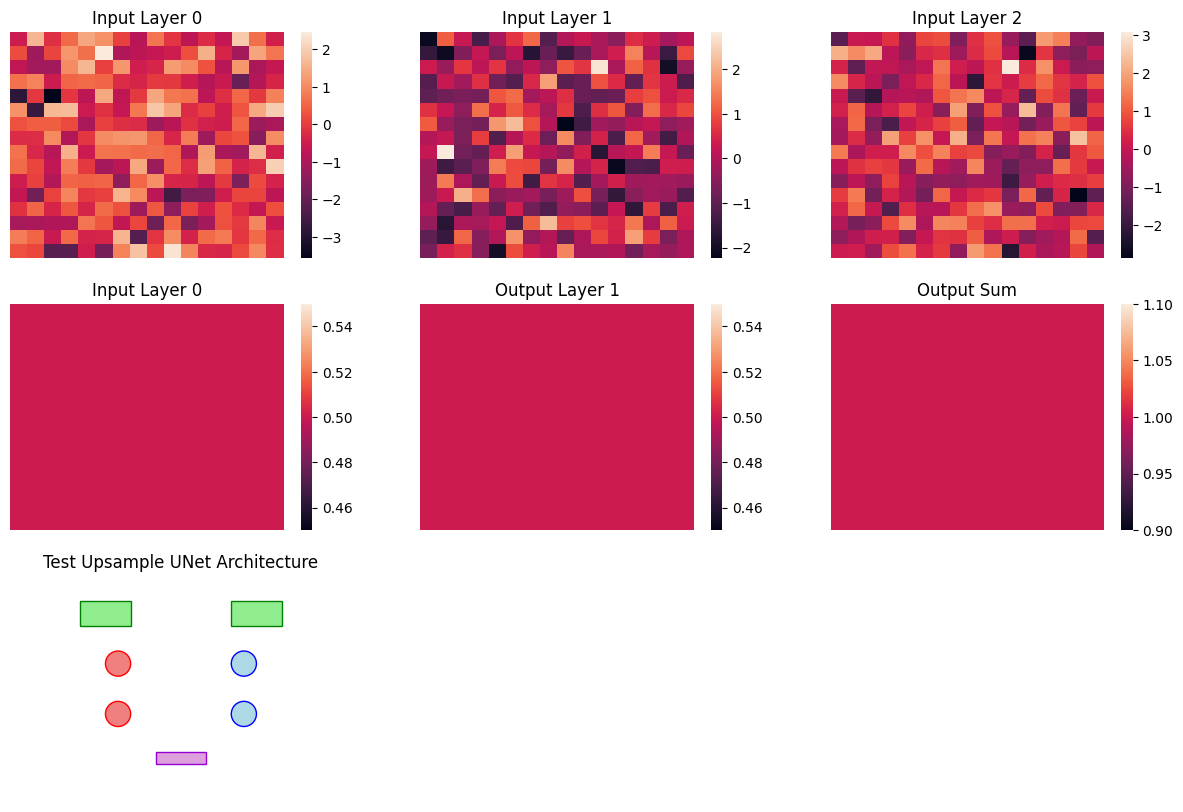

In [3]:
test_upsample = UNet("Test Upsample UNet", 3, 2, (4, 2, 2.), True, _print=False)

test_data = torch.randn(1, 3, 16, 16)
result = test_upsample.forward(test_data)

_, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
for i in range(3):
    for j in range(3):
        axes[i,j].axis('off')

sns.heatmap(test_data[0,0], ax=axes[0,0]).set(title="Input Layer 0")
sns.heatmap(test_data[0,1], ax=axes[0,1]).set(title="Input Layer 1")
sns.heatmap(test_data[0,2], ax=axes[0,2]).set(title="Input Layer 2")
sns.heatmap(result[0,0].detach(), ax=axes[1,0]).set(title="Input Layer 0")
sns.heatmap(result[0,1].detach(), ax=axes[1,1]).set(title="Output Layer 1")
sns.heatmap(result[0].sum(dim=0).detach(), ax=axes[1,2]).set(title="Output Sum")

test_upsample.draw(axes[2,0])
plt.show()

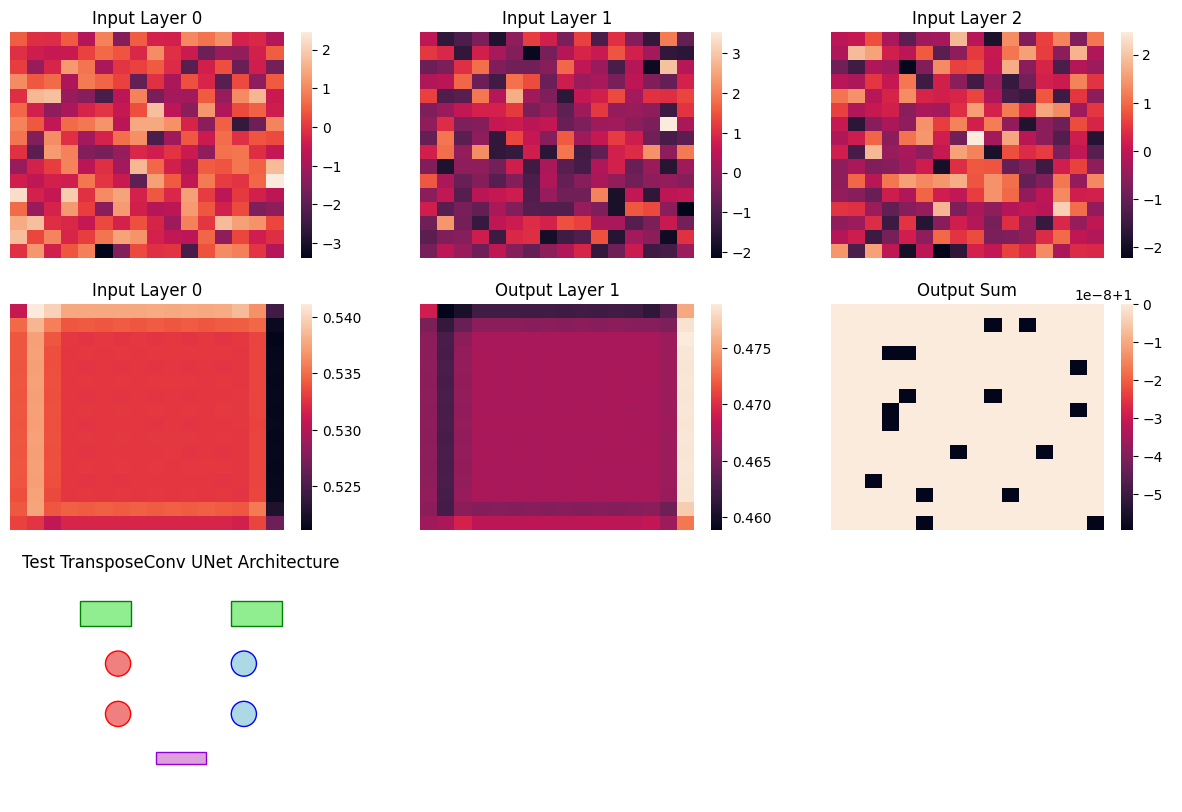

In [4]:
test_transpose = UNet("Test TransposeConv UNet", 3, 2, (4, 2, 2.), False, _print=False)

test_data = torch.randn(1, 3, 16, 16)
result = test_transpose.forward(test_data)

_, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
for i in range(3):
    for j in range(3):
        axes[i,j].axis('off')

sns.heatmap(test_data[0,0], ax=axes[0,0]).set(title="Input Layer 0")
sns.heatmap(test_data[0,1], ax=axes[0,1]).set(title="Input Layer 1")
sns.heatmap(test_data[0,2], ax=axes[0,2]).set(title="Input Layer 2")
sns.heatmap(result[0,0].detach(), ax=axes[1,0]).set(title="Input Layer 0")
sns.heatmap(result[0,1].detach(), ax=axes[1,1]).set(title="Output Layer 1")
sns.heatmap(result[0].sum(dim=0).detach(), ax=axes[1,2]).set(title="Output Sum")

test_transpose.draw(axes[2,0])
plt.show()

## Data

In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import v2

class PuzzleImages(Dataset):
    def __init__(self, description_dir, mask_dir, img_dir, type): 
        description = pd.read_csv(description_dir)
        self.description = description[description["type"] == type].reset_index() 
        self.img_dir = img_dir
        self.mask_dir = mask_dir

        self.image_transforms = v2.Compose([
            v2.Resize((512, 512))
        ])

    def __len__(self):
        return len(self.description)

    def __getitem__(self, idx):
        _, identifier, image_file, mask_file, img_type = self.description.loc[idx]
        image = self.image_transforms(read_image(f"{self.img_dir}/{image_file}").float() / 255)
        temp_mask = self.image_transforms(read_image(f"{self.mask_dir}/{mask_file}").float() / 255 > 0.5).float()

        mask = torch.cat([temp_mask, 1 - temp_mask], dim=0)
        return image, mask

In [6]:
train_dataset = PuzzleImages("./data.csv", "./masks", "./images", "train")
test_dataset = PuzzleImages("./data.csv", "./masks", "./images", "test")
val_dataset = PuzzleImages("./data.csv", "./masks", "./images", "val")

train_dataloader_demo = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader_demo = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataloader_demo = DataLoader(test_dataset, batch_size=1, shuffle=True)

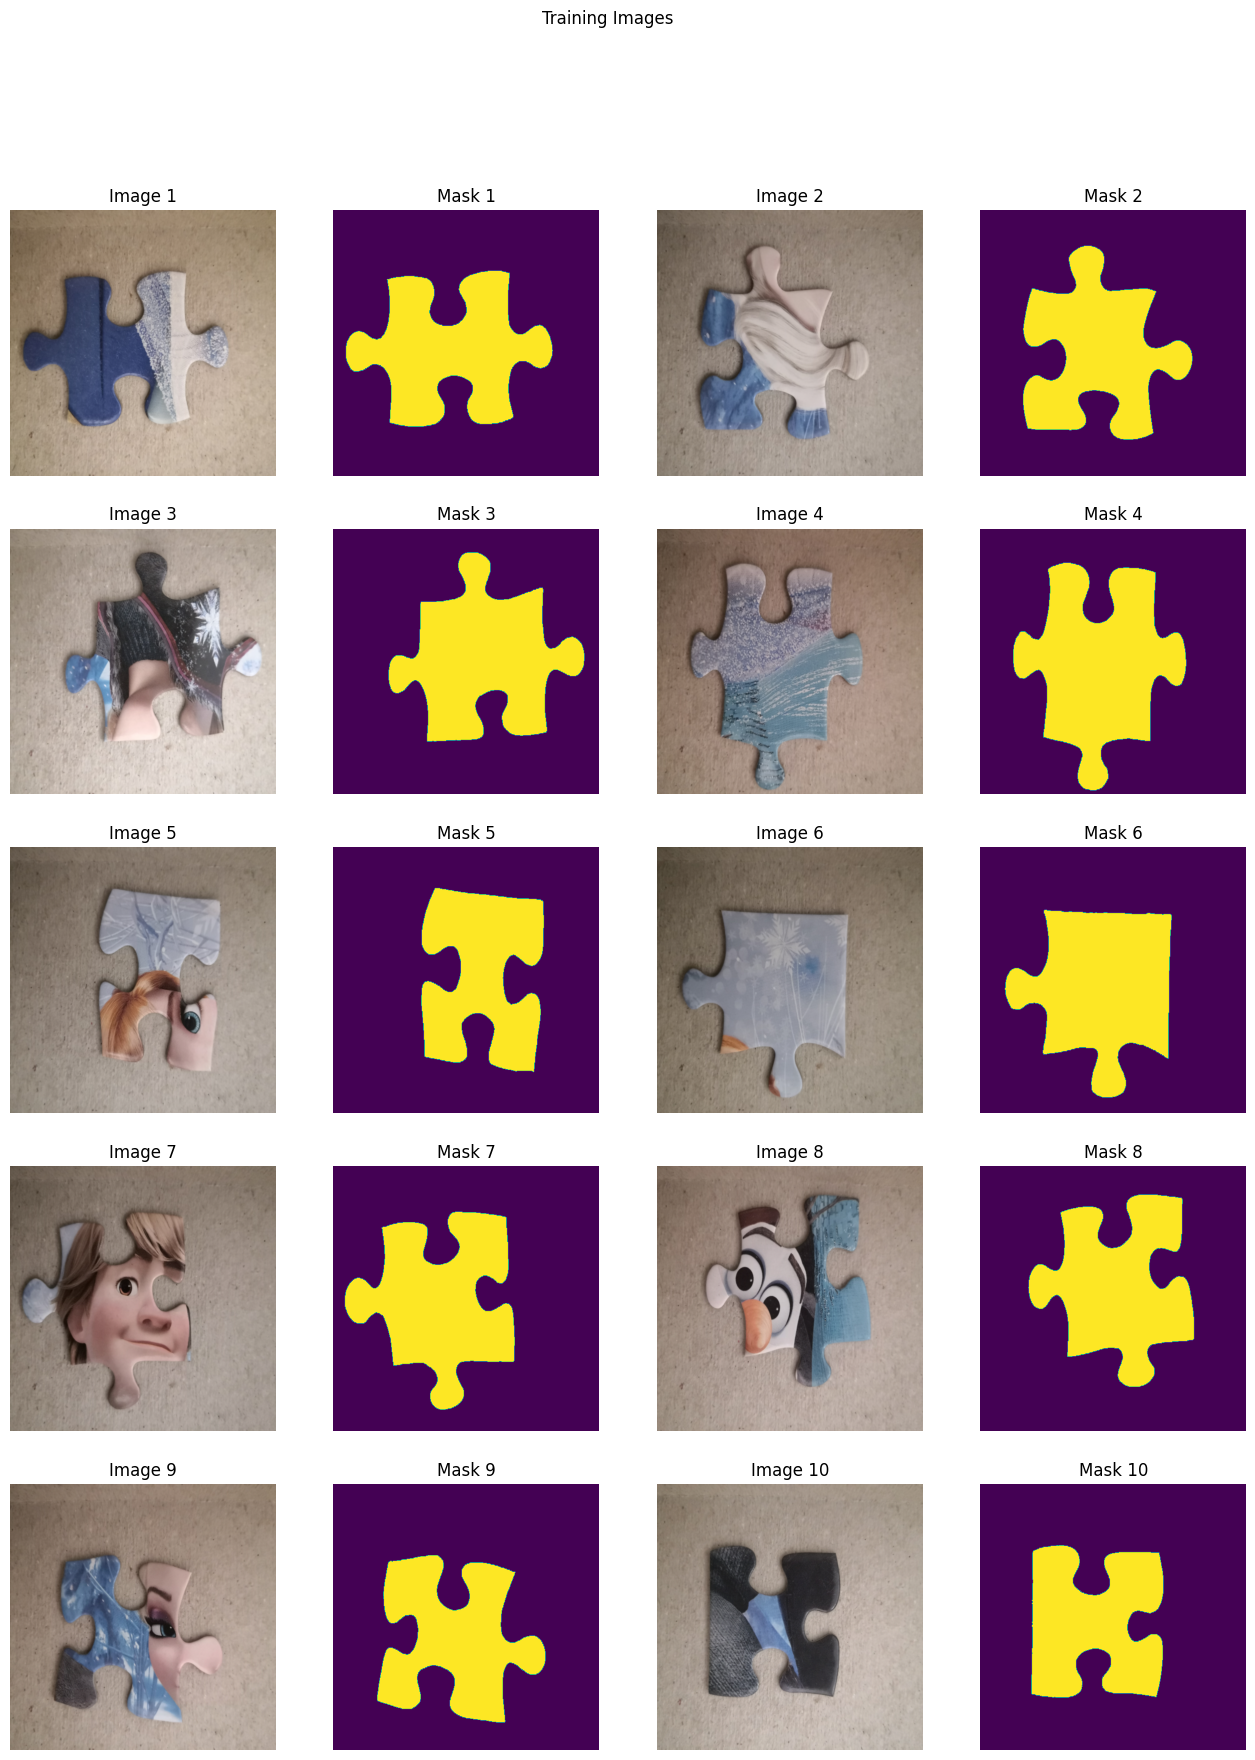

In [7]:
train_demo_rc = lambda i: (i % len(train_dataloader_demo) // 2, 2 * (i % 2), 2 * (i % 2) + 1)
fig, axes = plt.subplots(nrows=len(train_dataloader_demo) // 2, ncols=4, figsize=(16, len(train_dataloader_demo) // 2 * 4))
plt.suptitle("Training Images")
for i, (image, mask) in enumerate(train_dataloader_demo):
    row, image_col, mask_col = train_demo_rc(i)
    axes[row,image_col].axis('off')
    axes[row,mask_col].axis('off')

    axes[row,image_col].imshow(image[0].permute(1,2,0))
    axes[row,image_col].set_title(f"Image {i + 1}")
    axes[row,mask_col].imshow(mask[0,0])
    axes[row,mask_col].set_title(f"Mask {i + 1}")

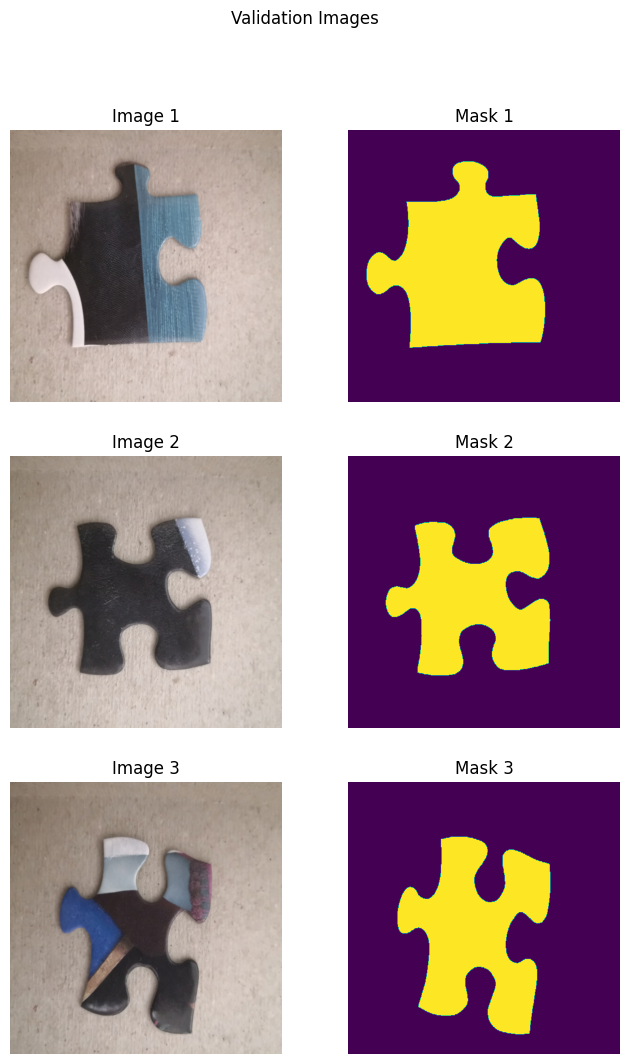

In [8]:
fig, axes = plt.subplots(nrows=len(val_dataloader_demo), ncols=2, figsize=(8, len(val_dataloader_demo) * 4))
plt.suptitle("Validation Images")
for i, (image, mask) in enumerate(val_dataloader_demo):
    axes[i,0].axis('off')
    axes[i,1].axis('off')

    axes[i,0].imshow(image[0].permute(1,2,0))
    axes[i,0].set_title(f"Image {i + 1}")
    axes[i,1].imshow(mask[0,0])
    axes[i,1].set_title(f"Mask {i + 1}")

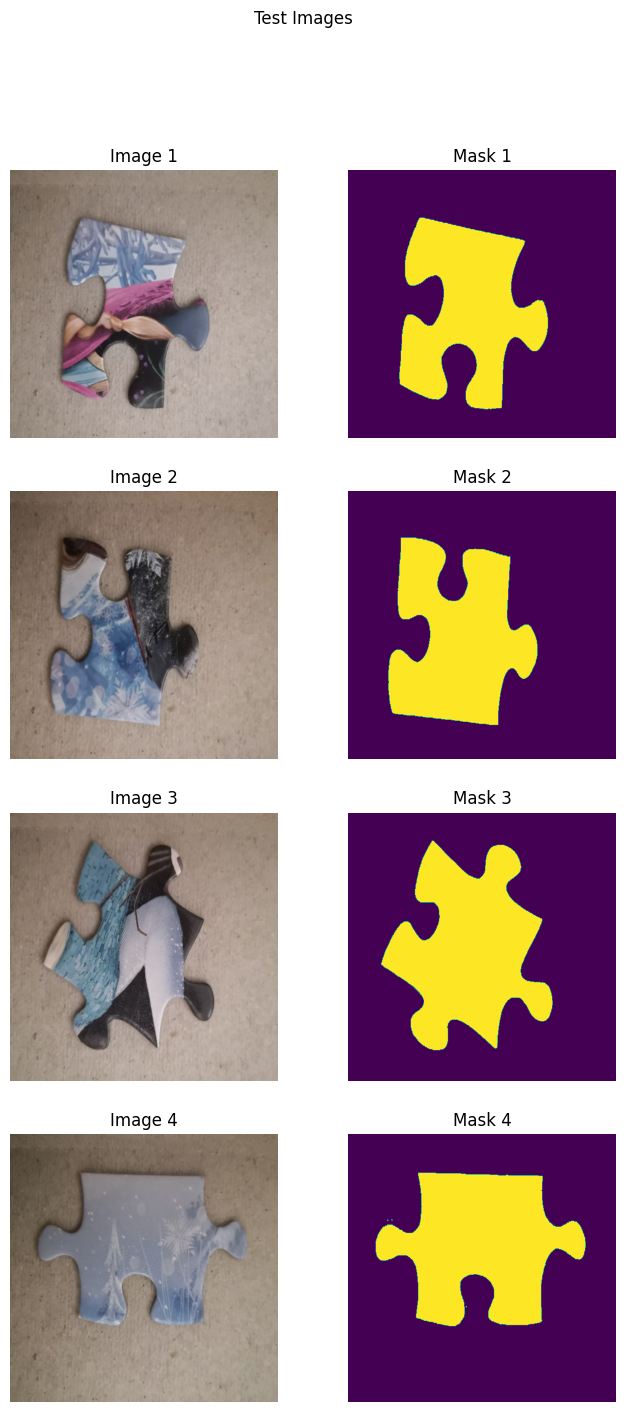

In [9]:
fig, axes = plt.subplots(nrows=len(test_dataloader_demo), ncols=2, figsize=(8, len(test_dataloader_demo) * 4))
plt.suptitle("Test Images")
for i, (image, mask) in enumerate(test_dataloader_demo):
    axes[i,0].axis('off')
    axes[i,1].axis('off')

    axes[i,0].imshow(image[0].permute(1,2,0))
    axes[i,0].set_title(f"Image {i + 1}")
    axes[i,1].imshow(mask[0,0])
    axes[i,1].set_title(f"Mask {i + 1}")

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

## Pipeline

In [11]:
def iou_score(input: torch.Tensor, target: torch.Tensor, threshold: float):
    union = ((input > threshold) | target.bool())
    intersection = ((input > threshold) & target.bool())

    return intersection.sum() / union.sum()

In [12]:
def training_pipeline(model, num_epochs, dataloaders, run_id, learning_rate = 0.001):
    device = ("cuda" if torch.cuda.is_available() else "cpu")
    thresholds = np.linspace(0., 1., 11)

    print(f"Training {model.unet_config['name']} for {num_epochs} epochs")
    print(f"Device: {device}")
    print("Hyperparameters:")
    print(f"\tThresholds = {thresholds}")
    print(f"\tLearning Rate = {learning_rate}")

    device_model = model.to(device = device)

    wandb.init(
        project="computer-vision-lab-3",
        name=f"{model.unet_config['name']}-run-{run_id}",
        config={
            "architecture": "UNet",
            "epochs": num_epochs,
            "thresholds": thresholds,
            "learning_rate": learning_rate
        }
    )

    for t in range(num_epochs):
        print(f"Epoch {t + 1}")
        # print(f"{'':=<60}")
        print("\tTraining")
        # print(f"{'':-<60}")
        train_res = train(device, device_model, dataloaders[0], thresholds, learning_rate=learning_rate)
        # print(f"\tAverage loss: {train_res['train/loss']}")
        # print(f"\tAverage IoU's: {train_res['train/IoU']}")
        # print(f"{'':=<60}")
        print("\tValidating")
        val_res = validate(device, device_model, dataloaders[1], thresholds)
        # print(f"\tAverage IoU's: {val_res['validate/IoU']}")
        # print(f"{'':-<60}")

        wandb.log(train_res | val_res)

    wandb.finish()

def train(device, model, dataloader, thresholds, learning_rate=0.001):
    num_batches = len(dataloader)

    model.train()
    loss_fn = tnn.BCELoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

    running_loss, running_fg_loss, running_bg_loss = 0., 0., 0.
    running_iou_score, running_iou_fg_score, running_iou_bg_score = np.zeros(thresholds.shape), np.zeros(thresholds.shape), np.zeros(thresholds.shape)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        prediction = model(X)
        loss = loss_fn(prediction, y)

        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        running_loss += loss.item()
        running_fg_loss += loss_fn(prediction[:,0], y[:,0]).item()
        running_bg_loss += loss_fn(prediction[:,1], y[:,0]).item()
        for i, th in enumerate(thresholds):
            running_iou_score[i] += iou_score(prediction, y, th)
            running_iou_fg_score[i] += iou_score(prediction[:,0], y[:,0], th)
            running_iou_bg_score[i] += iou_score(prediction[:,1], y[:,1], th)

    running_loss /= num_batches
    running_fg_loss /= num_batches
    running_bg_loss /= num_batches

    running_iou_score = running_iou_score / num_batches
    running_iou_fg_score = running_iou_fg_score / num_batches
    running_iou_bg_score = running_iou_bg_score / num_batches

    max_idx = np.argmax(running_iou_score)
    running_iou_max_threshold = thresholds[max_idx]
    running_iou_max = np.max(running_iou_score)
    running_iou_fg_max = running_iou_fg_score[max_idx]
    running_iou_bg_max = running_iou_bg_score[max_idx]

    return {
        "train/loss": running_loss,
        "train/fg_loss": running_fg_loss,
        "train/bg_loss": running_bg_loss,
        "train/IoU_threshold": running_iou_max_threshold,
        "train/IoU": running_iou_max,
        "train/fg_IoU": running_iou_fg_max,
        "train/bg_IoU": running_iou_bg_max,
    }

def validate(device, model, dataloader, thresholds):
    num_batches = len(dataloader)

    model.eval()
    loss_fn = tnn.BCELoss()

    running_loss, running_fg_loss, running_bg_loss = 0., 0., 0.
    running_iou_score, running_iou_fg_score, running_iou_bg_score = np.zeros(thresholds.shape), np.zeros(thresholds.shape), np.zeros(thresholds.shape)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            prediction = model(X)
            loss = loss_fn(prediction, y)

            running_loss += loss.item()
            running_fg_loss += loss_fn(prediction[:,0], y[:,0]).item()
            running_bg_loss += loss_fn(prediction[:,1], y[:,0]).item()
            for i, th in enumerate(thresholds):
                running_iou_score[i] += iou_score(prediction, y, th)
                running_iou_fg_score[i] += iou_score(prediction[:,0], y[:,0], th)
                running_iou_bg_score[i] += iou_score(prediction[:,1], y[:,1], th)

    running_loss /= num_batches
    running_fg_loss /= num_batches
    running_bg_loss /= num_batches

    running_iou_score = running_iou_score / num_batches
    running_iou_fg_score = running_iou_fg_score / num_batches
    running_iou_bg_score = running_iou_bg_score / num_batches

    max_idx = np.argmax(running_iou_score)
    running_iou_max_threshold = thresholds[max_idx]
    running_iou_max = np.max(running_iou_score)
    running_iou_fg_max = running_iou_fg_score[max_idx]
    running_iou_bg_max = running_iou_bg_score[max_idx]

    return {
        "validate/loss": running_loss,
        "validate/fg_loss": running_fg_loss,
        "validate/bg_loss": running_bg_loss,
        "validate/IoU_threshold": running_iou_max_threshold,
        "validate/IoU": running_iou_max,
        "validate/fg_IoU": running_iou_fg_max,
        "validate/bg_IoU": running_iou_bg_max,
    }


In [13]:
test_run = 0
upsample_run = 0
tranpose_run = 0

In [14]:
model = UNet("Test", 3, 2, (8, 1, 2.), True)
num_epochs = 20

test_run += 1
training_pipeline(model, num_epochs, [train_dataloader, val_dataloader], test_run)

Training Test for 20 epochs
Device: cuda
Hyperparameters:
	Thresholds = [0.   0.25 0.5  0.75 1.  ]
	Learning Rate = 0.001


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bgriffiths-2426285 (bgriffiths-2426285-university-of-the-witwatersrand). Use `wandb login --relogin` to force relogin


Epoch 1
	Training
	Validating
Epoch 2
	Training
	Validating
Epoch 3
	Training
	Validating
Epoch 4
	Training
	Validating
Epoch 5
	Training
	Validating
Epoch 6
	Training
	Validating
Epoch 7
	Training
	Validating
Epoch 8
	Training
	Validating
Epoch 9
	Training
	Validating
Epoch 10
	Training
	Validating
Epoch 11
	Training
	Validating
Epoch 12
	Training
	Validating
Epoch 13
	Training
	Validating
Epoch 14
	Training
	Validating
Epoch 15
	Training
	Validating
Epoch 16
	Training
	Validating
Epoch 17
	Training
	Validating
Epoch 18
	Training
	Validating
Epoch 19
	Training
	Validating
Epoch 20
	Training
	Validating


train/IoU,▁▁▁▁▁▁▁▁▁▁▅▁▇▄▄▁▃▃▁█
train/IoU_threshold,█████████▁▁▁▁▁▁█▁▁█▁
train/bg_IoU,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/bg_loss,▁▁▁▂▃▄▃▄▃▄▅▆▆▆▆▅▆▆▆█
train/fg_IoU,▁▁▁▁▁▁▁▁▁▅▆▅█▇▇▁▇▇▁█
train/fg_loss,██▇▅▅▅▄▄▄▄▃▄▂▃▁▃▁▁▂▁
train/loss,██▇▅▅▅▄▄▄▄▃▄▂▃▁▃▁▁▂▁
validate/IoU,▂▂▁▂▂▆▅▃▇▆▇▁▂▂▇▆▆▆█▁
validate/IoU_threshold,█████▁▁▁▁▁▁███▁▁▁▁▁█
validate/bg_IoU,▇█▁▇▇█▇▁█▇▁▁▇█▇▇█▇▇▁
validate/bg_loss,▁▁▁▃▃▃▃▃▃▃▃▂▃▂▄▇▆█▄▂


In [16]:
upsample_model = UNet("Upsampling Model", 3, 2, (64, 3, 2.), True)
num_epochs = 100

upsample_run += 1
training_pipeline(upsample_model, num_epochs, [train_dataloader, val_dataloader], upsample_run)

Training Upsampling Model for 40 epochs
Device: cuda
Hyperparameters:
	Thresholds = [0.   0.25 0.5  0.75 1.  ]
	Learning Rate = 0.001


Epoch 1
	Training
	Validating
Epoch 2
	Training
	Validating
Epoch 3
	Training
	Validating
Epoch 4
	Training
	Validating
Epoch 5
	Training
	Validating
Epoch 6
	Training
	Validating
Epoch 7
	Training
	Validating
Epoch 8
	Training
	Validating
Epoch 9
	Training
	Validating
Epoch 10
	Training
	Validating
Epoch 11
	Training
	Validating
Epoch 12
	Training
	Validating
Epoch 13
	Training
	Validating
Epoch 14
	Training
	Validating
Epoch 15
	Training
	Validating
Epoch 16
	Training
	Validating
Epoch 17
	Training
	Validating
Epoch 18
	Training
	Validating
Epoch 19
	Training
	Validating
Epoch 20
	Training
	Validating
Epoch 21
	Training
	Validating
Epoch 22
	Training
	Validating
Epoch 23
	Training
	Validating
Epoch 24
	Training
	Validating
Epoch 25
	Training
	Validating
Epoch 26
	Training
	Validating
Epoch 27
	Training
	Validating
Epoch 28
	Training
	Validating
Epoch 29
	Training
	Validating
Epoch 30
	Training
	Validating
Epoch 31
	Training
	Validating
Epoch 32
	Training
	Validating
Epoch 33
	Trainin

train/IoU,▇▂▃▅▁▅▂▃▅▄▄▃▇▆▆▃▇██▇▄▅▄▇▇▄▅▃▆█▁▇▂▄▃▃▂▂▄▅
train/IoU_threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/bg_IoU,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/bg_loss,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/fg_IoU,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/fg_loss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train/loss,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
validate/IoU,██▇█▇▇██▇▁▁█▇██▁█████▁▁▁▁▁██▁██▇█▇██▇█▇▁
validate/IoU_threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validate/bg_IoU,██▇█▇▇██▇▁▁█▇██▁█████▁▁▁▁▁██▁██▇█▇██▇█▇▁
validate/bg_loss,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▃▄▄▄▄▅▄▅▅▅▅▆▆▆▆▇▇▇▇▇█████
